In [1]:
# import glm_utils
import glm_utils.preprocessing, glm_utils.bases
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection, sklearn.metrics, sklearn.linear_model
from scipy.stats import zscore, binned_statistic, pearsonr
import os
import pickle
import pandas as pd
import itertools as itt
import seaborn as sns
from DN_tools import load_into_pandas, bases_dict, load_recording, get_xy, lp, chunked_test_train_split
from tqdm import tqdm

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")

In [ ]:
color_perside_dict = {'MDN':'#207FC3','imposter left':'#D83088','imposter right':'k', 'DopaMeander left':'#D83088','DopaMeander right':'k','DNp17':'goldenrod','Roadrunner':'SeaGreen'}
color_perDN_dict = {'MDN':'#207FC3','imposter':'#D83088','DopaMeander':'#D83088','DNp17':'goldenrod','Roadrunner':'SeaGreen'}

labels_dict = {'v_fwd':r'$v_{fwd}$','v_ang':r'$v_{ang}$','abs_v_fwd':r'$|v_{fwd}|$','abs_v_ang':r'$|v_{ang}|$','pos_v_fwd':r'$v_{fwd}^+$','pos_v_ang':r'$v_{ang}^+$','neg_v_fwd':r'$v_{fwd}^-$','neg_v_ang':r'$v_{ang}^-$'}

raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
sample_frequency = 20000
isplit = 0 # nsplits = 5
bin_width = 100; decimating_values = [10,10]
datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
# y_names = ['pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
# y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']
cutoff = 20
block_size = 5_000; n_block_min=5; test_size = 0.35; random_state = 42; starting_nbins = 32
window = bases_dict['window']

df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[(df.to_ignore == False)&(df.DN != "Roadrunner")].reset_index(drop=True)

# Current analysis and store intermediate results for plotting

In [3]:
analysis_name = 'continuous_NL_all' # 'continuous_all'
apply_NL = True
redo_analysis = True

if redo_analysis or os.path.exists(raw_data_dir_path+f'/dat/{analysis_name}_y_m.pkl'):
    analysis_df = df.copy()

    B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
    B = B[-window:]
    basis_projection = glm_utils.preprocessing.BasisProjection(B)

    analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']

    y_m_dict = {}
    y_pred_dict = {}

    for index, row in tqdm(analysis_df.iterrows(),total=70):
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']
        csv_path = row['abs_file_path']

        singleDN_df = load_recording(csv_path=csv_path)

        x, ys = get_xy(singleDN_df,analysis_ynames)
        X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
        X_b = basis_projection.transform(X)

        y_pred = np.zeros_like(y_m)
        for ivar, varname in enumerate(analysis_ynames):
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    model = temp["model"]
                    y_pred[:,ivar] = model.predict(X_b)

                if apply_NL:
                    # Attempt to estimate nonlinearity (last record: ~12% constant value)
                    nbins = starting_nbins
                    not_finished = True
                    while (nbins != 5) and not_finished:
                        bin_edges_quantilebased = np.quantile(y_pred[:,ivar], np.linspace(0, 1, nbins + 1))
                        try:
                            statistic, bin_edges, binnumber = binned_statistic(y_pred[:,ivar], y_m[:,ivar], statistic='mean', bins=bin_edges_quantilebased, range=None)
                            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
                            constant_input = False
                            not_finished = False
                        except ValueError as e:
                            if str(e) != 'The smallest edge difference is numerically 0.':
                                print("ValueError: ",e)
                            else:
                                nbins -= 1

                    if (nbins == 5) and not_finished:
                        statistic = [np.nanmean(y_m[:,ivar])]
                        bin_centers = [np.nanmean(y_pred[:,ivar])]
                        constant_input = True

                    if np.sum(np.isnan(statistic)) > 0:
                        y_pred[:,ivar] = np.interp(y_pred[:,ivar], bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
                    else:
                        y_pred[:,ivar] = np.interp(y_pred[:,ivar], bin_centers, statistic)

        y_m_dict[filename] = y_m
        y_pred_dict[filename] = y_pred

    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_m.pkl', 'wb') as handle:
        pickle.dump(y_m_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_pred.pkl', 'wb') as handle:
        pickle.dump(y_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [17:29<00:00, 14.99s/it]


# Unsure of we are using the rest of the code

In [3]:
if redo_analysis:
    analysis_df = df.copy()

    B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
    B = B[-window:]
    basis_projection = glm_utils.preprocessing.BasisProjection(B)

    analysis_ynames = ["v_fwd","abs_v_ang"]

    y_m_dict = {}
    y_pred_dict = {}

    for index, row in analysis_df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']
        csv_path = row['abs_file_path']

        singleDN_df = load_recording(csv_path=csv_path)

        x, ys = get_xy(singleDN_df,analysis_ynames)
        X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
        X_b = basis_projection.transform(X)

        y_pred = np.zeros_like(y_m)
        for ivar, varname in enumerate(analysis_ynames):
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    model = temp["model"]
                    y_pred[:,ivar] = model.predict(X_b)

        y_m_dict[filename] = y_m
        y_pred_dict[filename] = y_pred

    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_m_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


    analysis_ynames = ["v_fwd","v_ang"]

    y_m_dict = {}
    y_pred_dict = {}

    for index, row in analysis_df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']
        csv_path = row['abs_file_path']

        singleDN_df = load_recording(csv_path=csv_path)

        x, ys = get_xy(singleDN_df,analysis_ynames)
        X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
        X_b = basis_projection.transform(X)

        y_pred = np.zeros_like(y_m)
        for ivar, varname in enumerate(analysis_ynames):
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    model = temp["model"]
                    y_pred[:,ivar] = model.predict(X_b)

        y_m_dict[filename] = y_m
        y_pred_dict[filename] = y_pred

    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_m_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    analysis_ynames = ["abs_v_fwd","abs_v_ang"]

    y_m_dict = {}
    y_pred_dict = {}

    for index, row in analysis_df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']
        csv_path = row['abs_file_path']

        singleDN_df = load_recording(csv_path=csv_path)

        x, ys = get_xy(singleDN_df,analysis_ynames)
        X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
        X_b = basis_projection.transform(X)

        y_pred = np.zeros_like(y_m)
        for ivar, varname in enumerate(analysis_ynames):
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    model = temp["model"]
                    y_pred[:,ivar] = model.predict(X_b)

        y_m_dict[filename] = y_m
        y_pred_dict[filename] = y_pred

    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_m_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'wb') as handle:
        pickle.dump(y_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


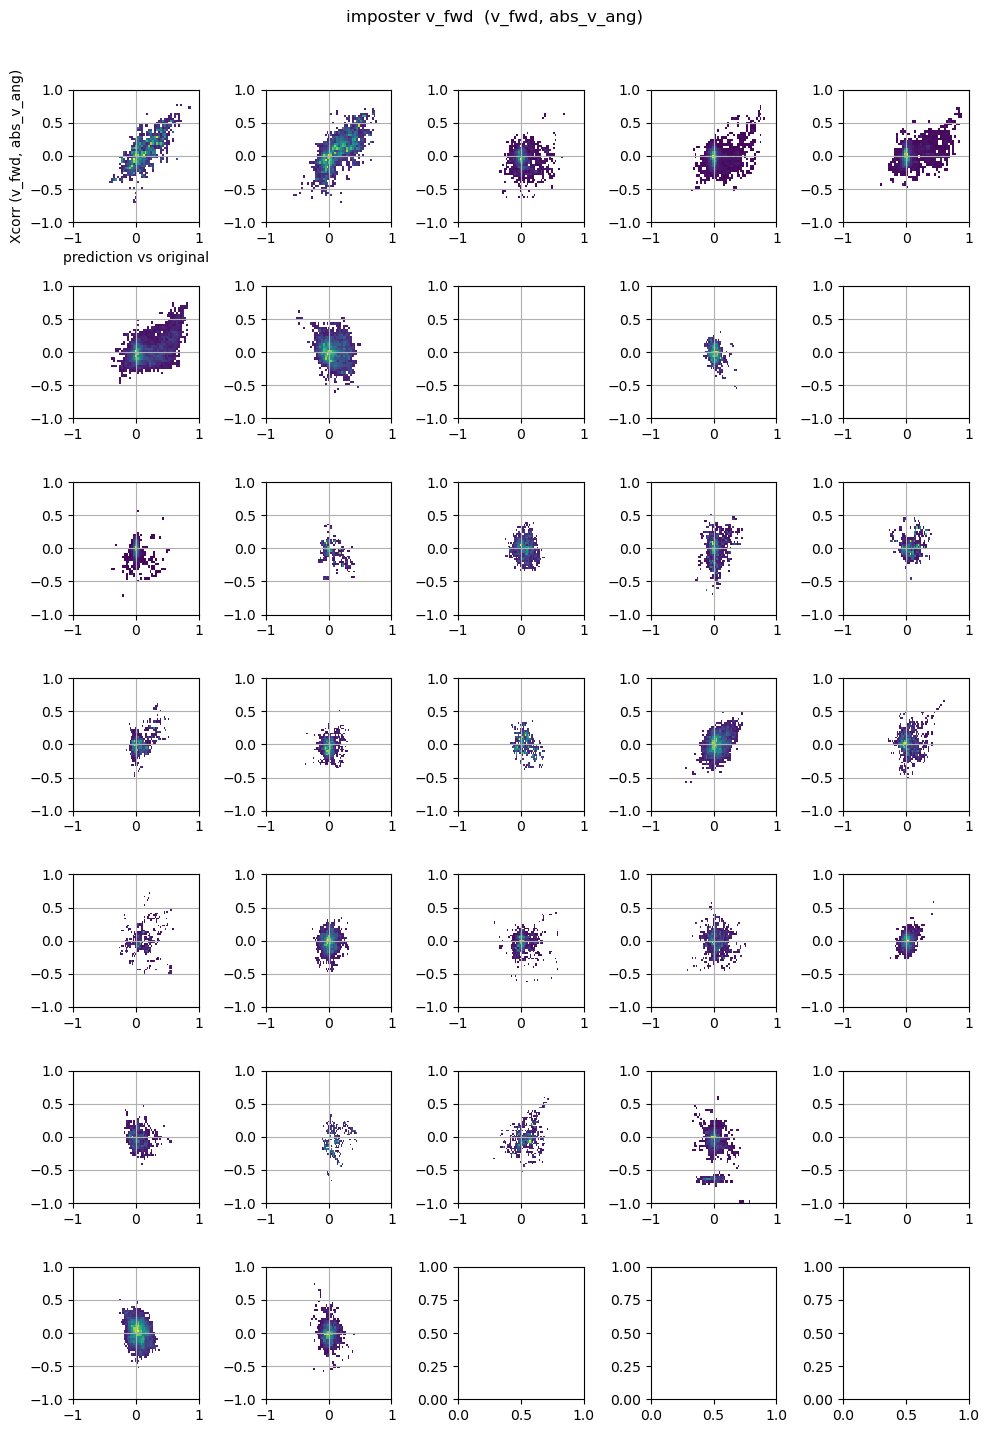

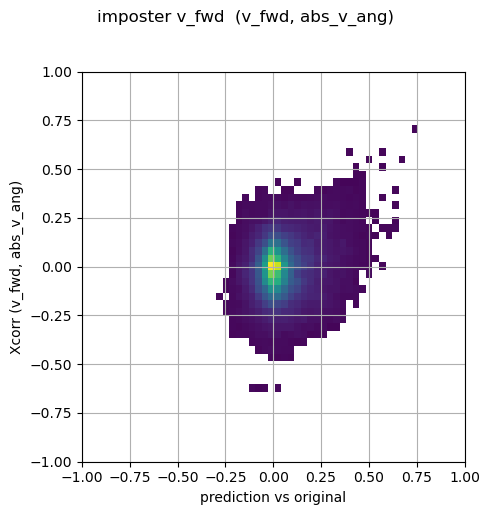

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


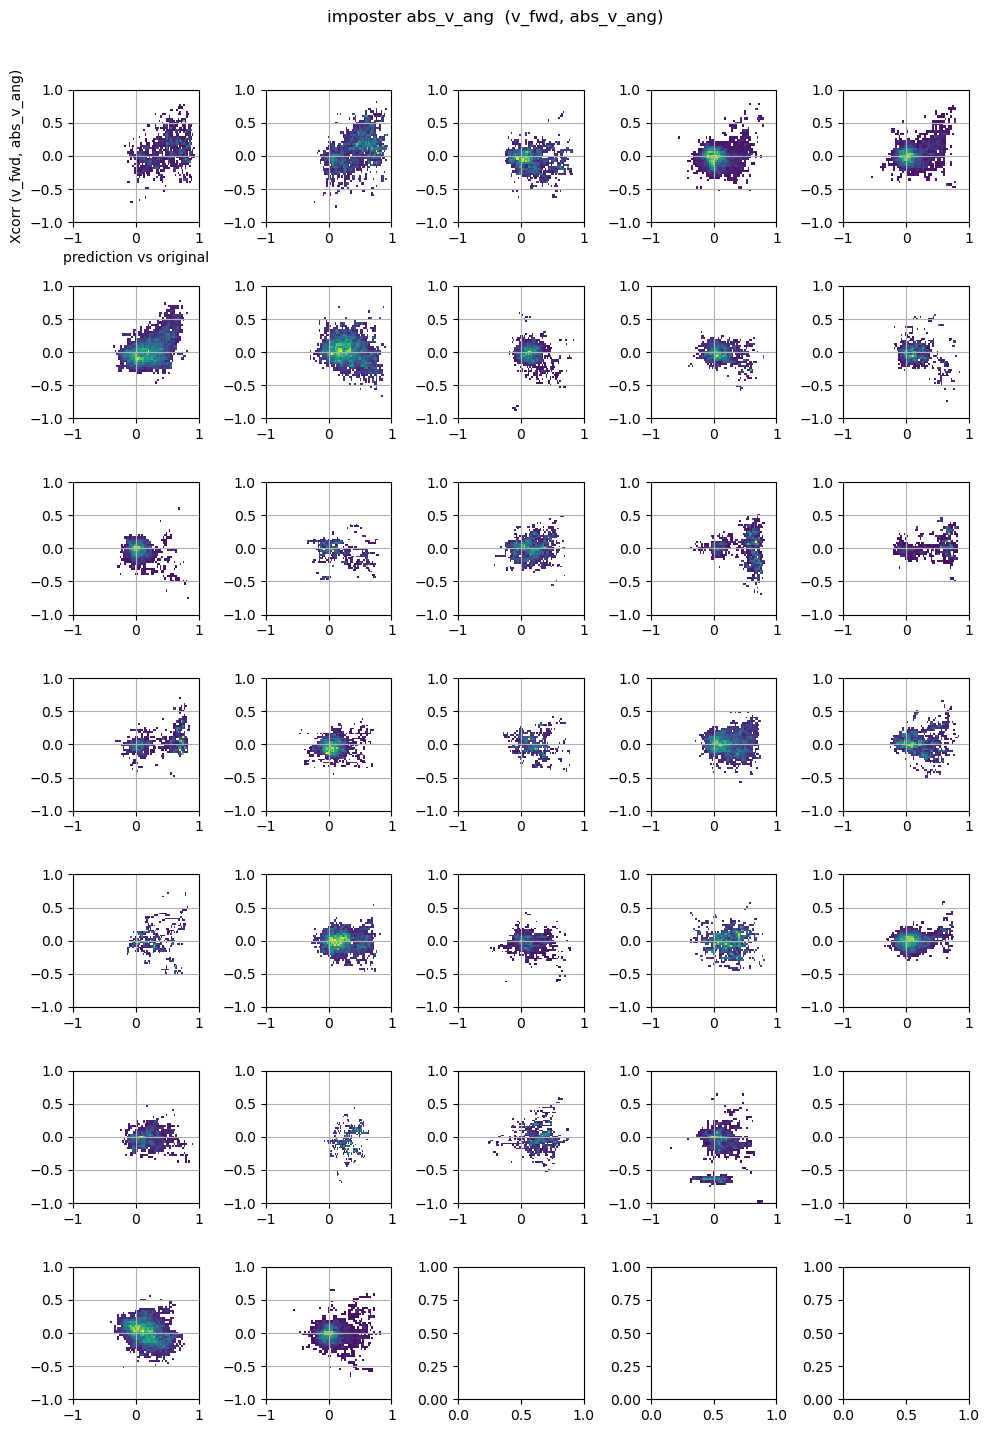

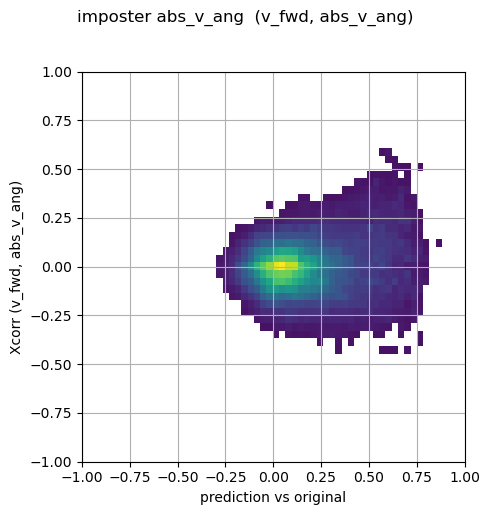

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


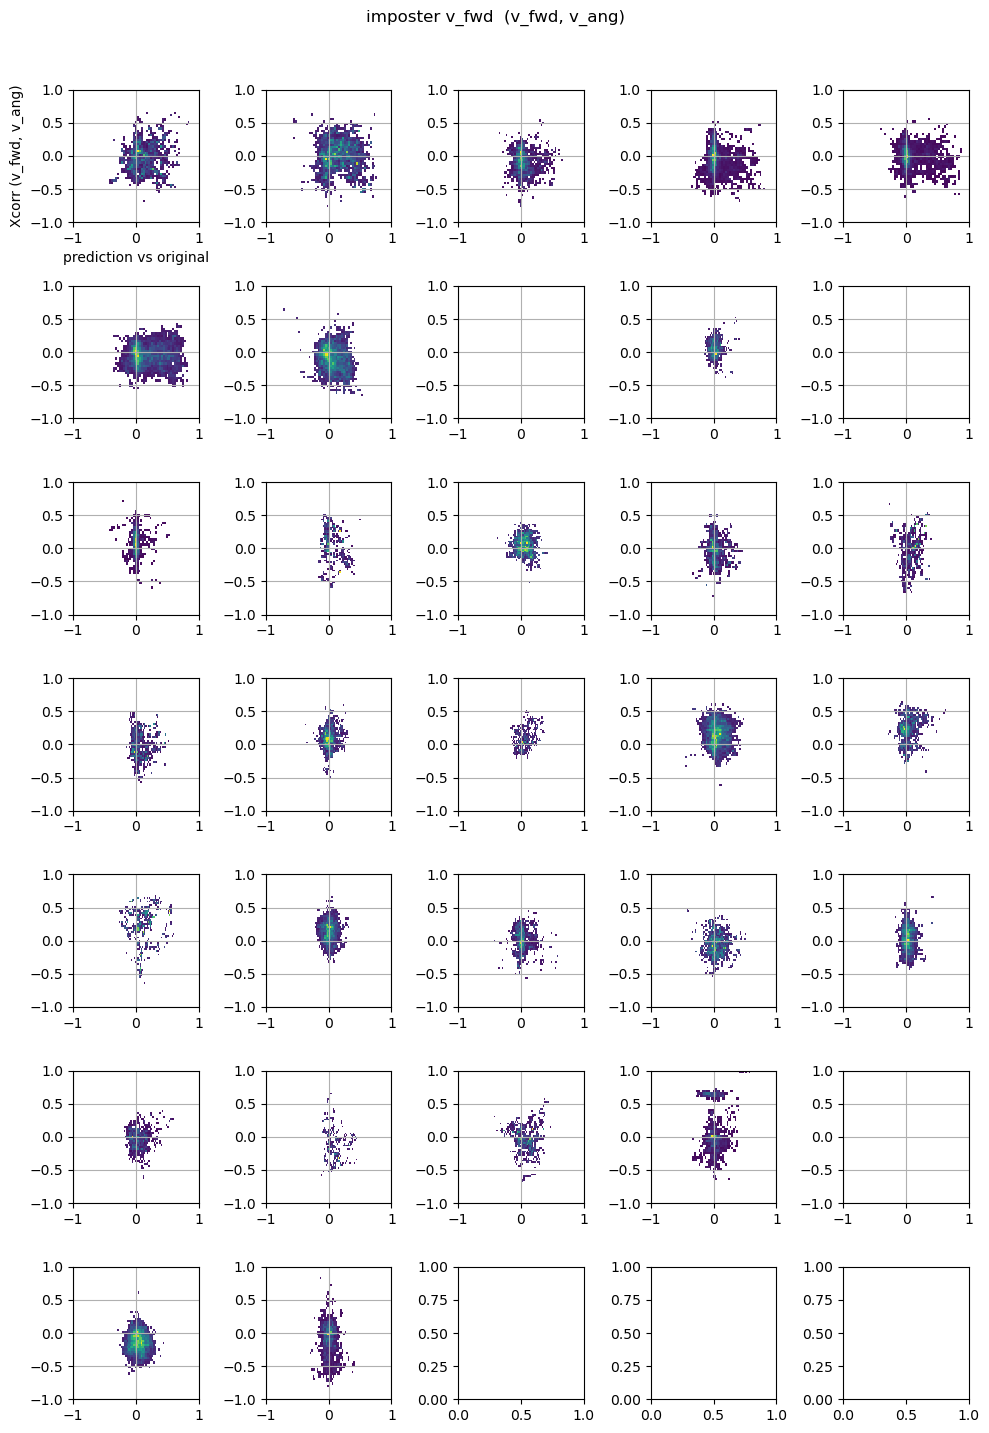

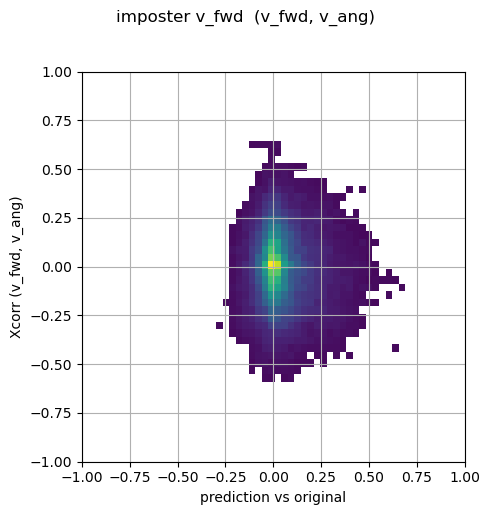

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


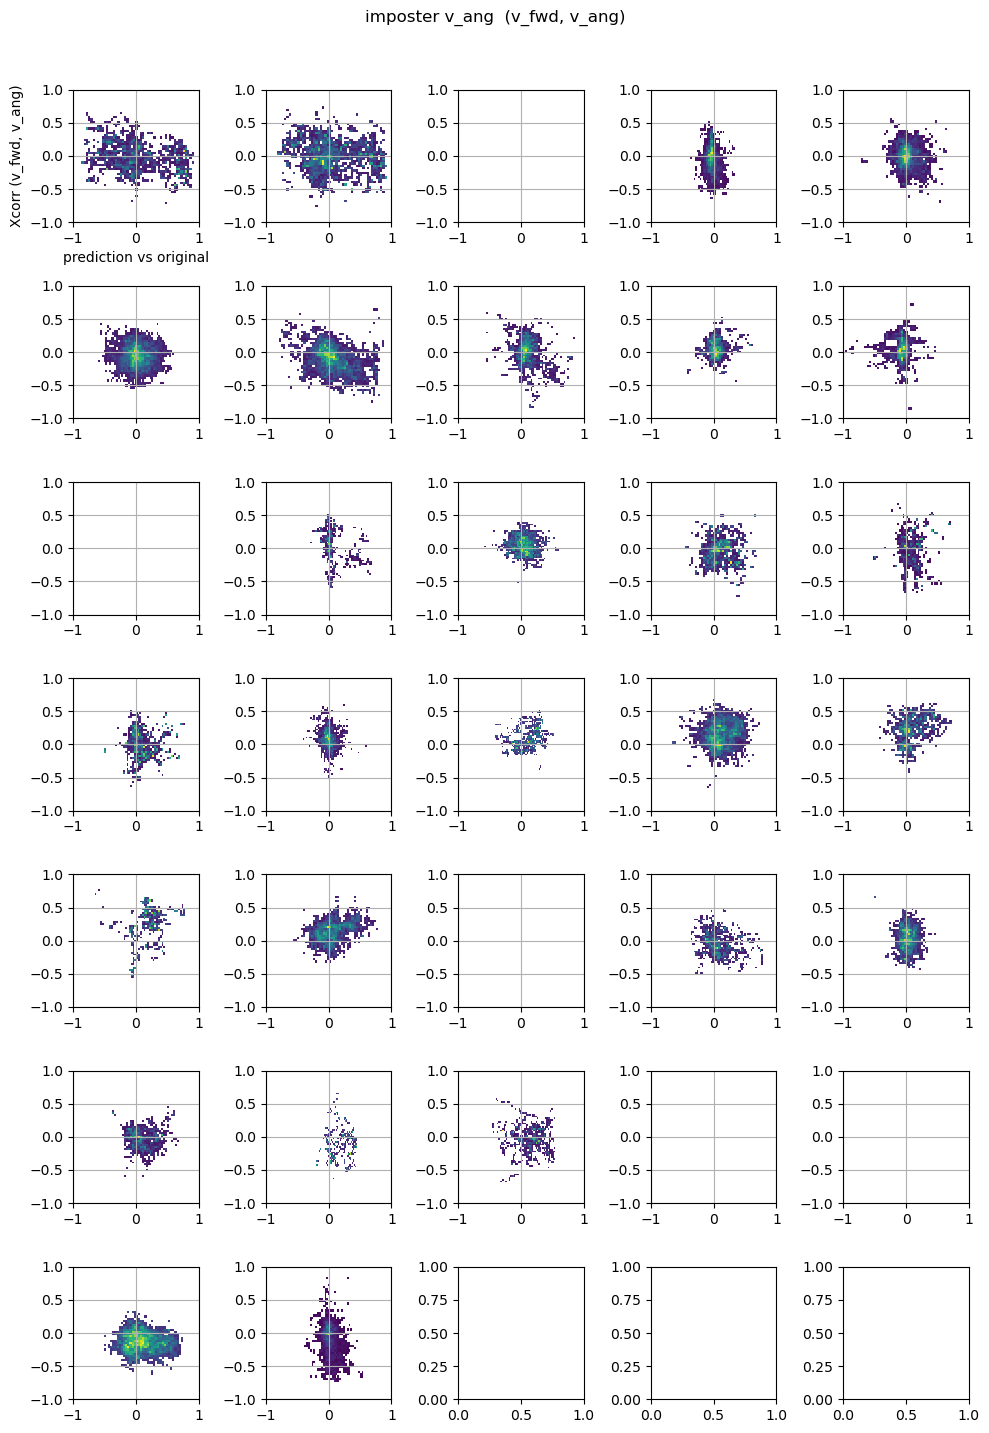

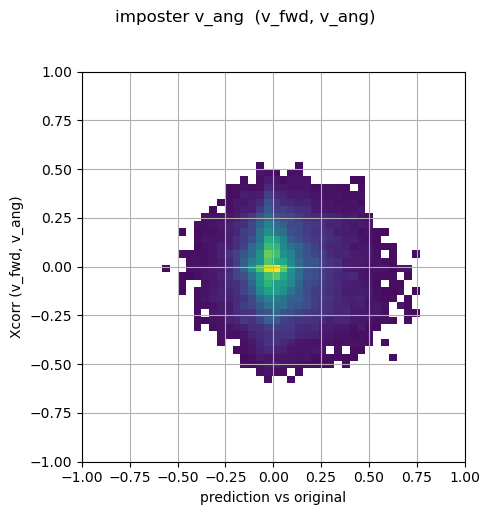

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


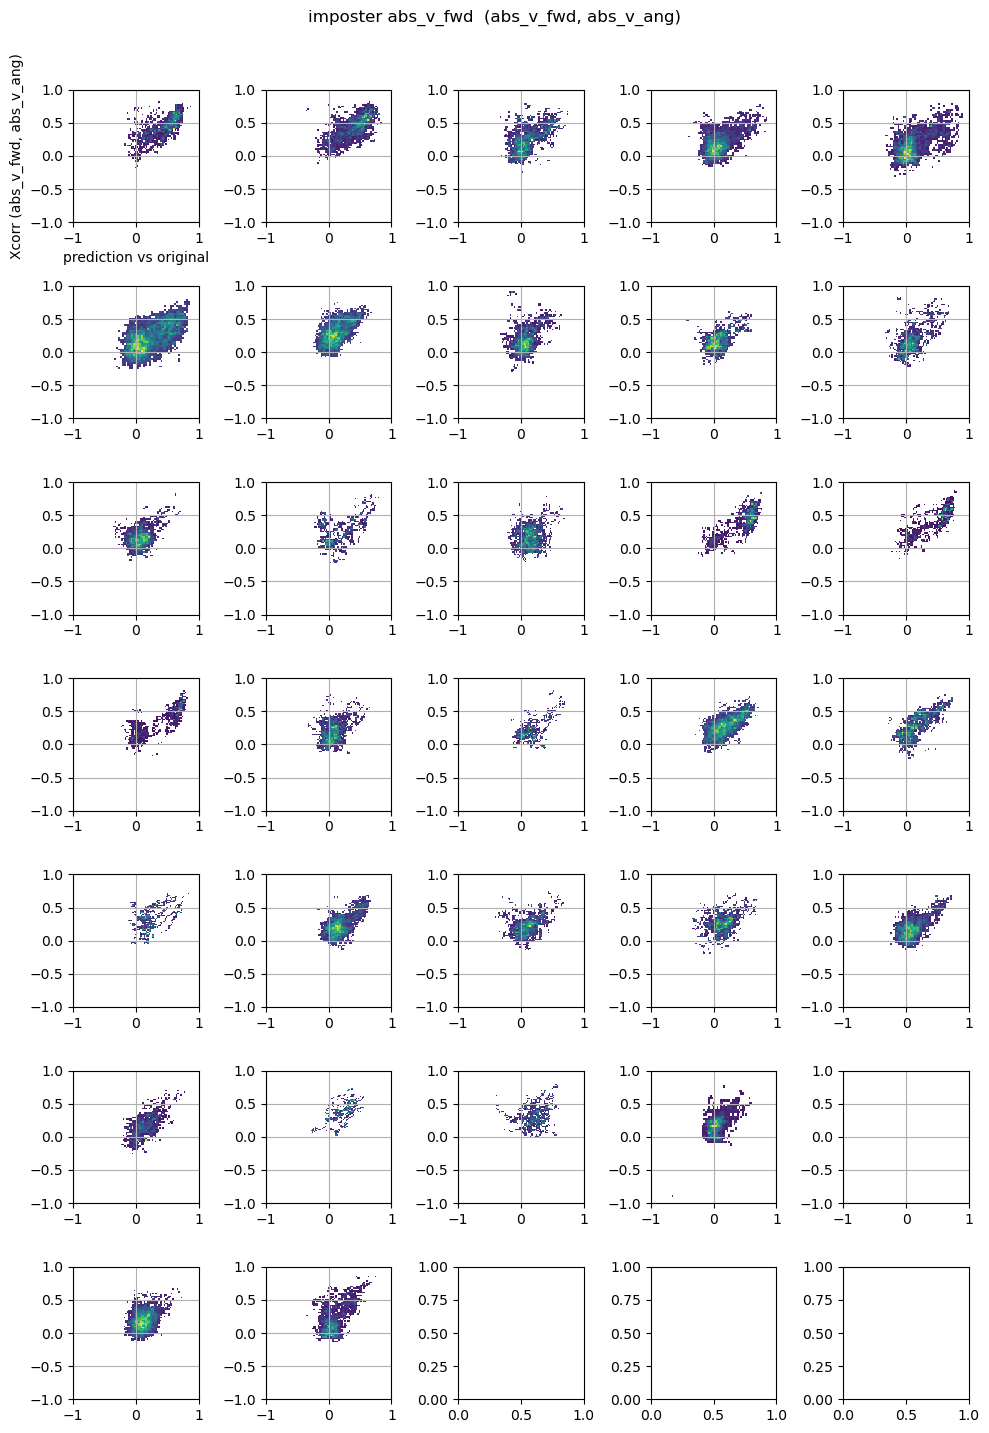

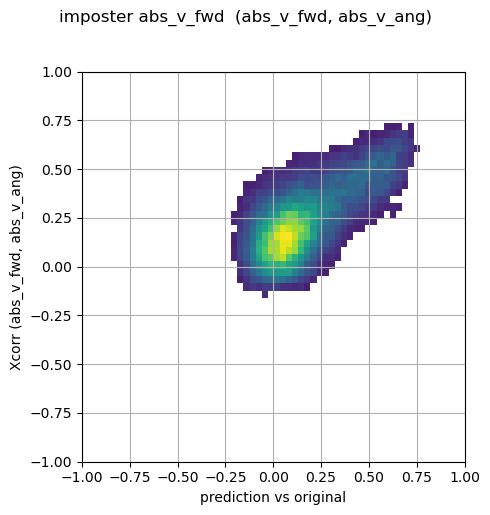

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


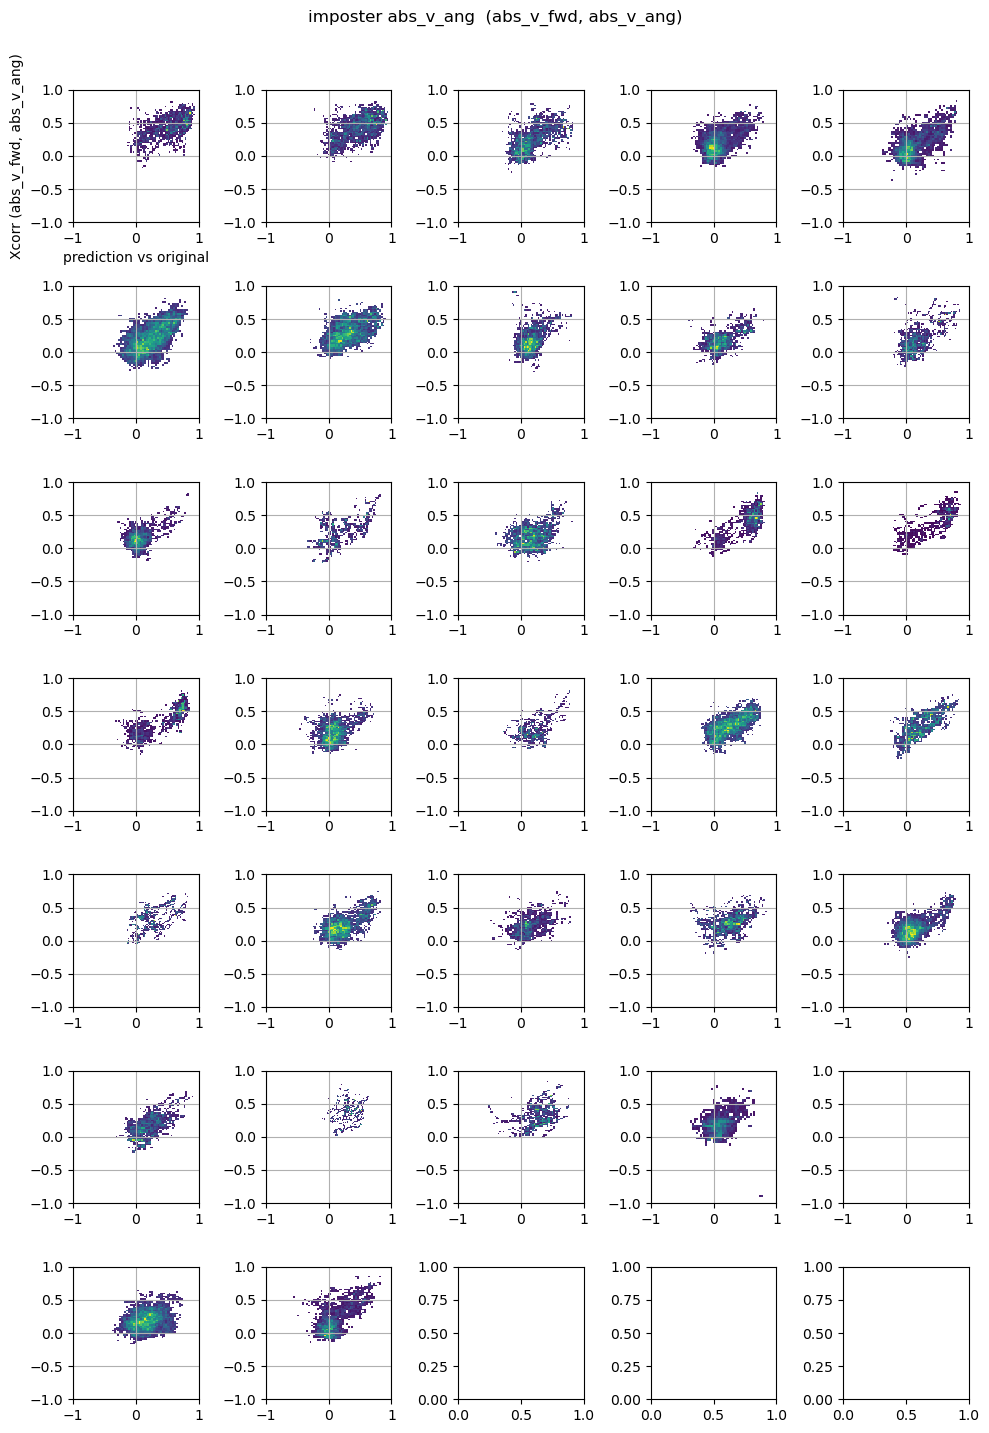

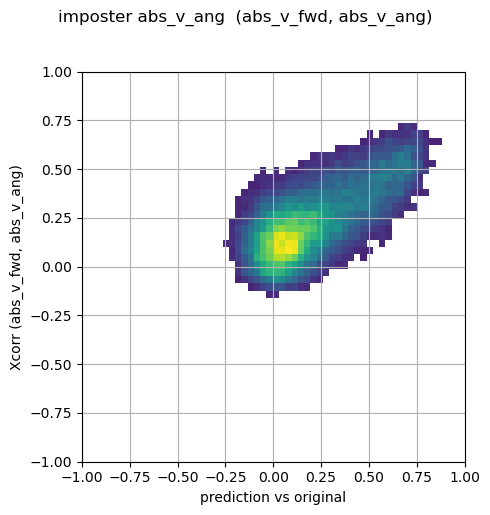

In [6]:
DN = 'imposter'
plot_df = df[df.DN == DN].copy().reset_index(drop=True)
nrows = np.ceil(len(plot_df.filename.unique().tolist())/5).astype(int)
ncols = 5

for analysis_ynames in (["v_fwd","abs_v_ang"], ["v_fwd","v_ang"], ["abs_v_fwd","abs_v_ang"]):
    
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
        y_m_dict = pickle.load(handle)
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
        y_pred_dict = pickle.load(handle)
   
    for ifeature in range(2):
        fig, axes = plt.subplots(nrows,ncols,figsize=(2*ncols, 2*nrows))
        axes = axes.flatten()

        conc_x_list = []
        conc_y_list = []
        for ax, filename in zip(axes,plot_df.filename.unique().tolist()):
            y_m = y_m_dict[filename]
            y_pred = y_pred_dict[filename]
            rolling_xcorr_variables = pd.Series(y_m[:,0]).rolling(window=window).corr(pd.Series(y_m[:,1]))
            rolling_corr_prediction = pd.Series(y_m[:,ifeature]).rolling(window=window).corr(pd.Series(y_pred[:,ifeature]))
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_xcorr_variables)
            x = rolling_corr_prediction[mask]
            y = rolling_xcorr_variables[mask]
            conc_x_list.append(x)
            conc_y_list.append(y)

            sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="viridis",ax=ax)

            ax.grid(True)
            ax.set_xlim([-1,1])
            ax.set_ylim([-1,1])
            ax.set_xlabel("")
            ax.set_ylabel("")
        axes[0].set_xlabel(f"prediction vs original")
        axes[0].set_ylabel("Xcorr ({0}, {1})".format(*analysis_ynames))
        plt.suptitle(f"{DN} {analysis_ynames[ifeature]} " + " ({0}, {1})".format(*analysis_ynames),y=1.02)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=[5,5])
        ax=plt.gca()
        conc_x = np.hstack(conc_x_list)
        conc_y = np.hstack(conc_y_list)
        sns.histplot(x=conc_x, y=conc_y, bins=50, pthresh=.1, cmap="viridis",ax=ax)
        ax.grid(True)
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_xlabel(f"prediction vs original")
        ax.set_ylabel("Xcorr ({0}, {1})".format(*analysis_ynames))
        plt.suptitle(f"{DN} {analysis_ynames[ifeature]} " + " ({0}, {1})".format(*analysis_ynames),y=1.02)
        plt.tight_layout()
        plt.show()

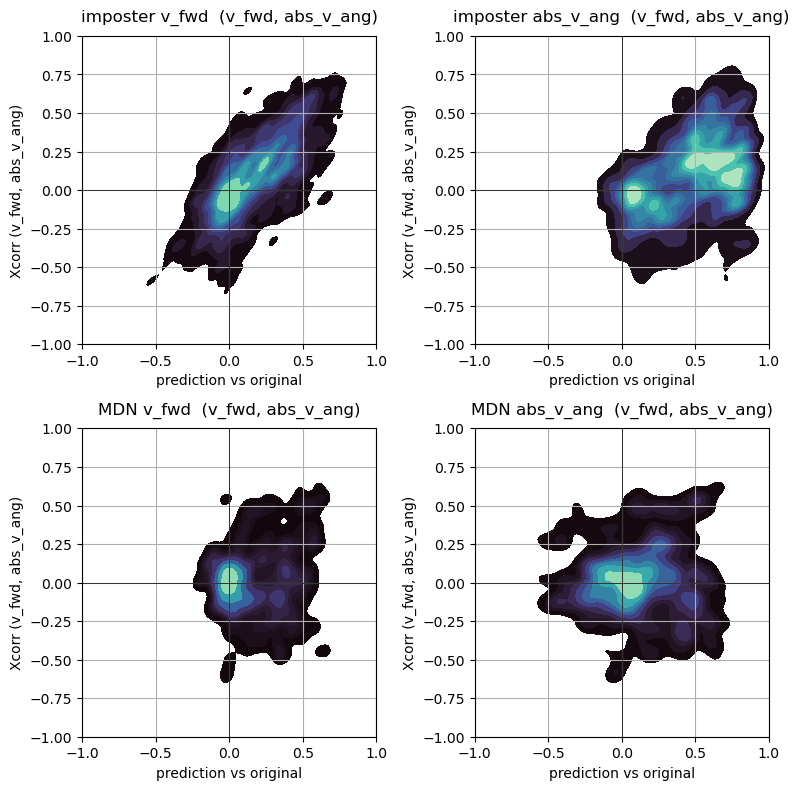

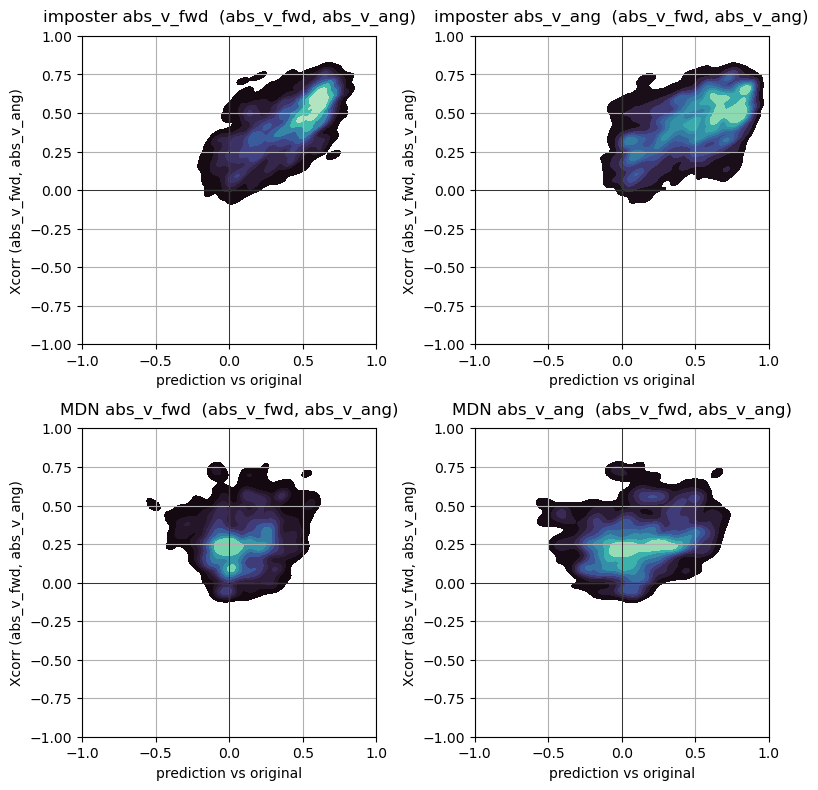

In [ ]:
for analysis_ynames in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):

    fig, axes = plt.subplots(2,2,figsize=(8, 8))

    for iDN, DN in enumerate(['imposter','MDN']):
        plot_df = df[df.DN == DN].copy().reset_index(drop=True)
            
        with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
            y_m_dict = pickle.load(handle)
        with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
            y_pred_dict = pickle.load(handle)
    
        for ifeature in range(2):
            conc_x_list = []
            conc_y_list = []
            for ax, filename in zip(axes,plot_df.filename.unique().tolist()):
                y_m = y_m_dict[filename]
                y_pred = y_pred_dict[filename]
                rolling_xcorr_variables = pd.Series(y_m[:,0]).rolling(window=window).corr(pd.Series(y_m[:,1]))
                rolling_corr_prediction = pd.Series(y_m[:,ifeature]).rolling(window=window).corr(pd.Series(y_pred[:,ifeature]))
                mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_xcorr_variables)
                x = rolling_corr_prediction[mask]
                y = rolling_xcorr_variables[mask]
                conc_x_list.append(x)
                conc_y_list.append(y)


            ax = axes[iDN,ifeature]
            conc_x = np.hstack(conc_x_list)
            conc_y = np.hstack(conc_y_list)
            ax.axhline(y=0,color='k',lw=1)
            ax.axvline(x=0,color='k',lw=1)
            # sns.histplot(x=conc_x, y=conc_y, bins=50, pthresh=.1, cmap="viridis",ax=ax)
            sns.kdeplot(x=conc_x, y=conc_y, fill=True, cmap="mako", thresh=0.05, ax=ax)
            ax.grid(True)
            ax.set_xlim([-1,1])
            ax.set_ylim([-1,1])
            ax.set_xlabel(f"prediction vs original")
            ax.set_ylabel("Xcorr ({0}, {1})".format(*analysis_ynames))
            ax.set_title(f"{DN} {analysis_ynames[ifeature]} " + " ({0}, {1})".format(*analysis_ynames),y=1.02)
    plt.tight_layout()
    plt.show()

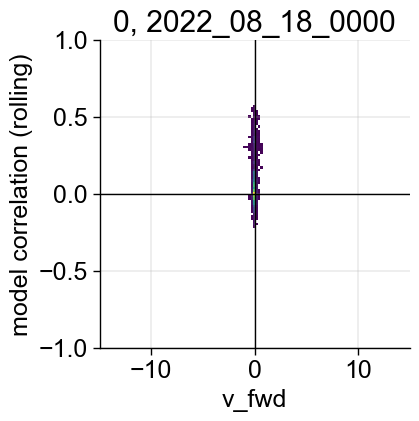

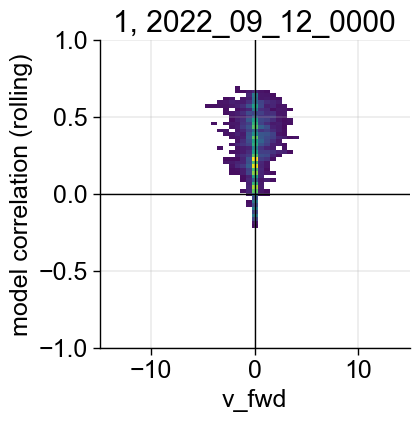

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


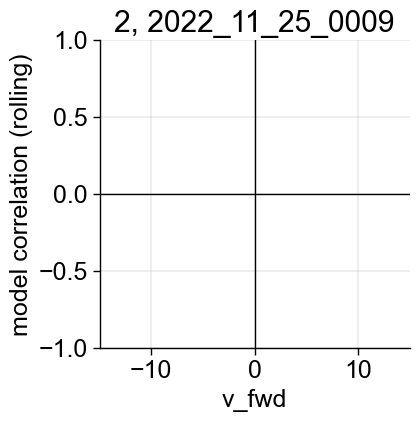

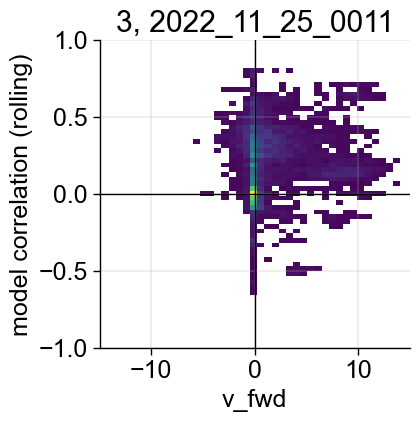

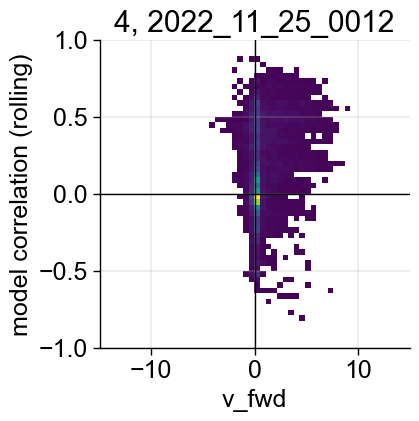

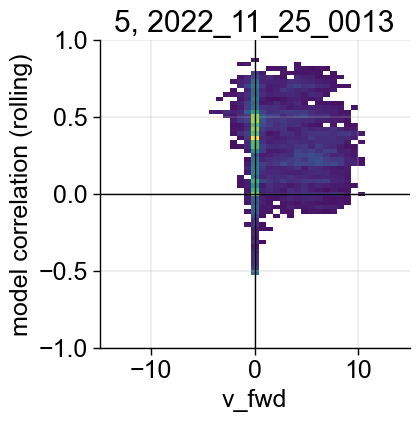

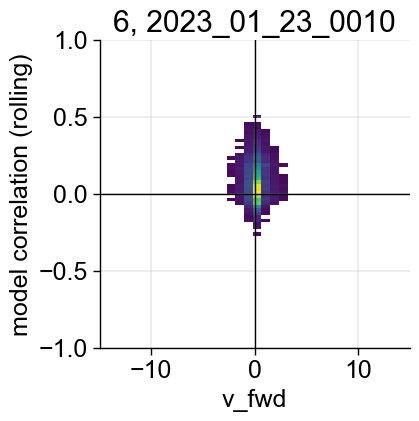

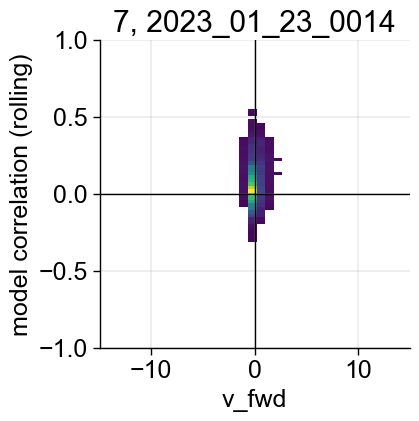

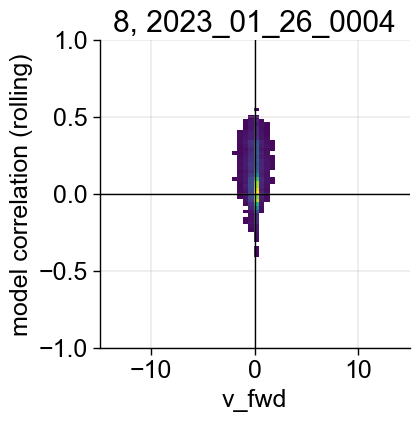

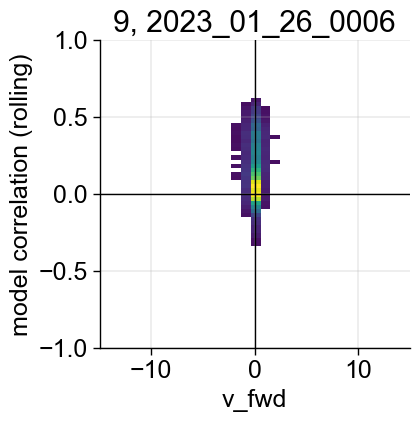

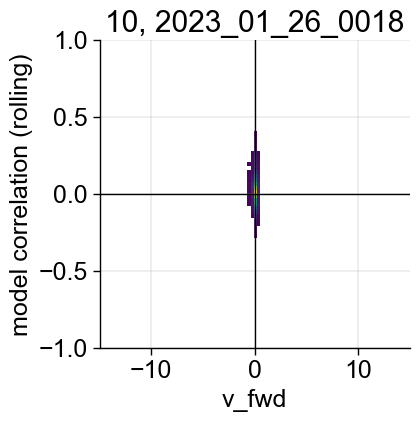

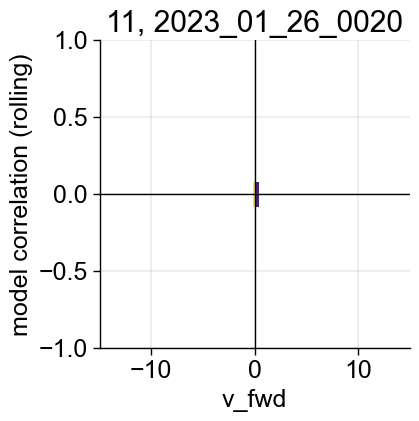

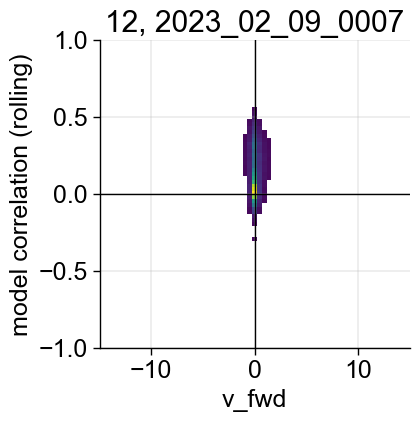

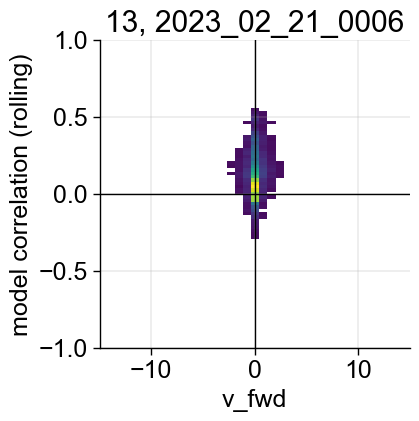

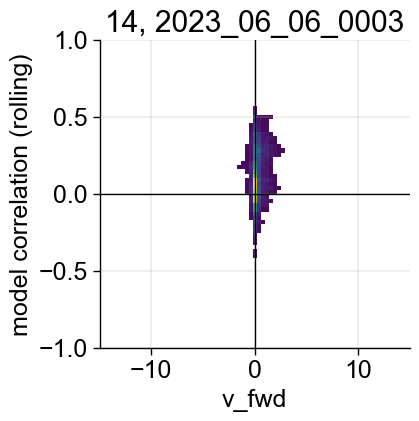

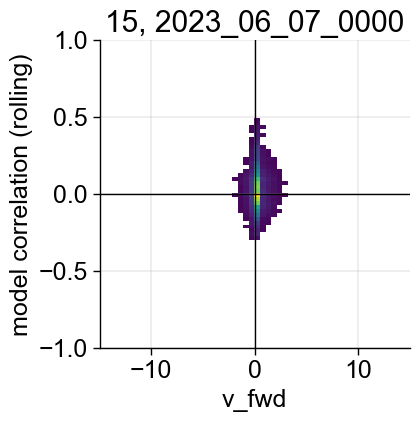

c:\mambaforge\envs\glm_kans\Lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


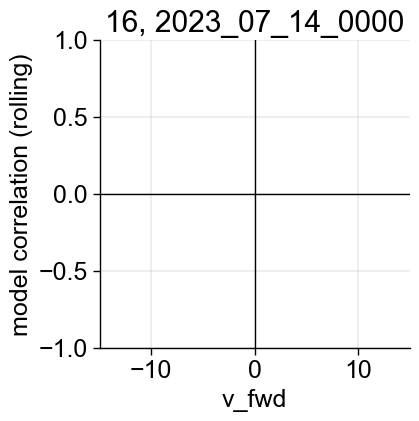

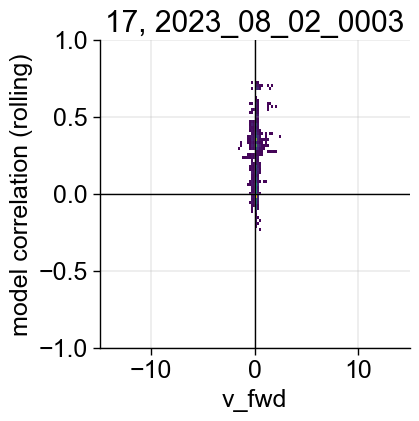

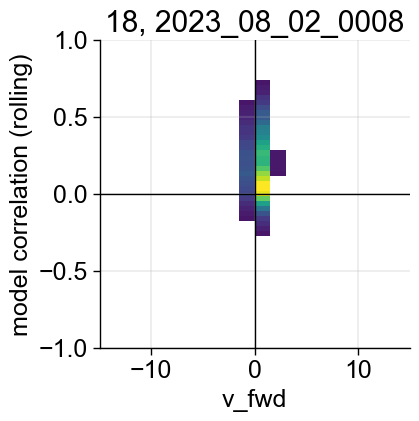

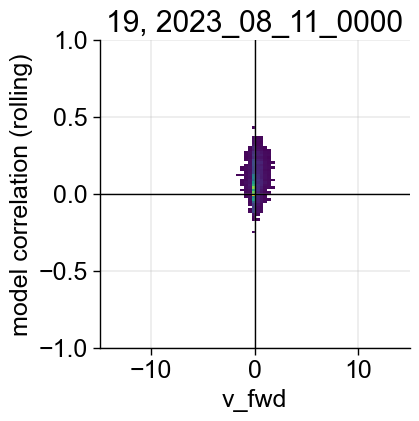

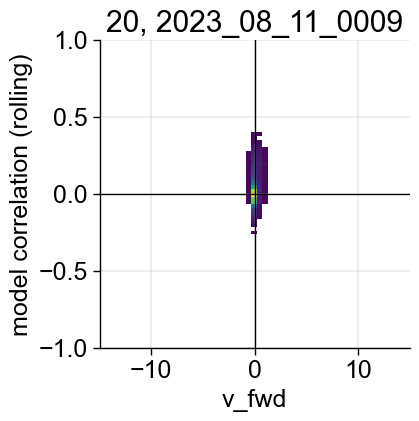

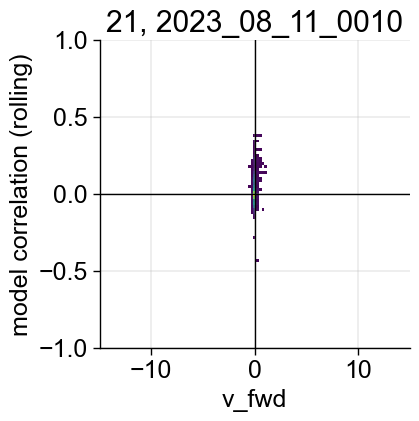

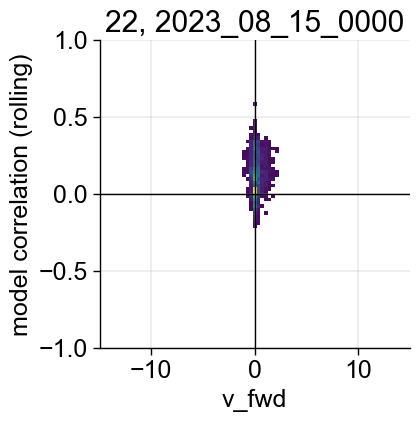

In [41]:
analysis_ynames = ["v_fwd","abs_v_ang"]
plot_df = df[df.DN == 'MDN'].copy().reset_index(drop=True)

with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
    y_pred_dict = pickle.load(handle)

# index = 1
# row = plot_df.iloc[index]
for index, row in plot_df.iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']
    csv_path = row['abs_file_path']

    ifeature = 0
    y_m = y_m_dict[filename]
    y_pred = y_pred_dict[filename]
    rolling_xcorr_variables = pd.Series(y_m[:,0]).rolling(window=window).corr(pd.Series(y_m[:,1]))
    rolling_corr_prediction = pd.Series(y_m[:,ifeature]).rolling(window=window).corr(pd.Series(y_pred[:,ifeature]))
    mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_xcorr_variables)

    plt.figure(figsize=[4,4])
    ax = plt.gca()
    ax.grid(True,lw=0.3)
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)
    # sns.kdeplot(x=y_m[mask,ifeature], y=rolling_corr_prediction[mask], fill=True, cmap="mako", thresh=0.05)
    sns.histplot(x=y_m[mask,ifeature], y=rolling_corr_prediction[mask], bins=50, pthresh=.1, cmap="viridis", ax=ax)
    ax.set_ylim([-1,1])
    ax.set_xlim([-15,15])
    ax.set_ylabel('model correlation (rolling)')
    ax.set_xlabel(f"{analysis_ynames[ifeature]}")
    ax.set_title(f"{index}, {filename}")
    plt.show()

In [ ]:
# for analysis_ynames in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):

#     fig, axes = plt.subplots(2,2,figsize=(8, 8))

#     for iDN, DN in enumerate(['MDN']):
#         plot_df = df[df.DN == DN].copy().reset_index(drop=True)
            
#         with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
#             y_m_dict = pickle.load(handle)
#         with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
#             y_pred_dict = pickle.load(handle)
    
#         ifeature = 0
#         conc_x_list = []
#         conc_y_list = []
#         for ax, filename in zip(axes,plot_df.filename.unique().tolist()):
#             y_m = y_m_dict[filename]
#             y_pred = y_pred_dict[filename]
#             rolling_xcorr_variables = pd.Series(y_m[:,0]).rolling(window=window).corr(pd.Series(y_m[:,1]))
#             rolling_corr_prediction = pd.Series(y_m[:,ifeature]).rolling(window=window).corr(pd.Series(y_pred[:,ifeature]))
#             mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_xcorr_variables)
            
#             x = rolling_corr_prediction[mask]
#             y = rolling_xcorr_variables[mask]
#             conc_x_list.append(x)
#             conc_y_list.append(y)


#         ax = axes[iDN,ifeature]
#         conc_x = np.hstack(conc_x_list)
#         conc_y = np.hstack(conc_y_list)
#         ax.axhline(y=0,color='k',lw=1)
#         ax.axvline(x=0,color='k',lw=1)
#         # sns.histplot(x=conc_x, y=conc_y, bins=50, pthresh=.1, cmap="viridis",ax=ax)
#         sns.kdeplot(x=conc_x, y=conc_y, fill=True, cmap="mako", thresh=0.05, ax=ax)
#         ax.grid(True)
#         ax.set_xlim([-1,1])
#         ax.set_ylim([-1,1])
#         ax.set_xlabel(f"prediction vs original")
#         ax.set_ylabel("Xcorr ({0}, {1})".format(*analysis_ynames))
#         ax.set_title(f"{DN} {analysis_ynames[ifeature]} " + " ({0}, {1})".format(*analysis_ynames),y=1.02)
#     plt.tight_layout()
#     plt.show()

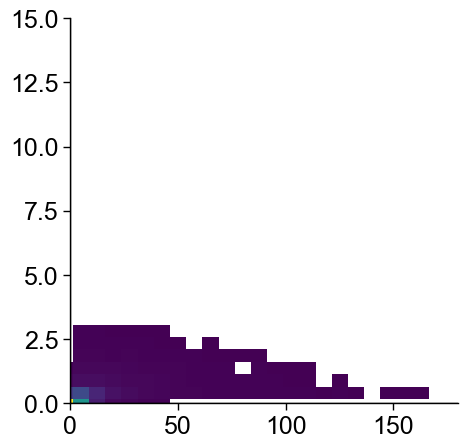

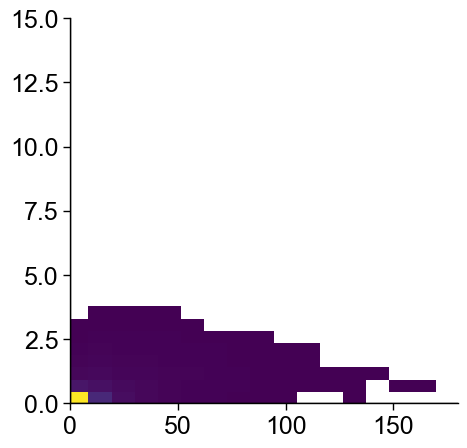

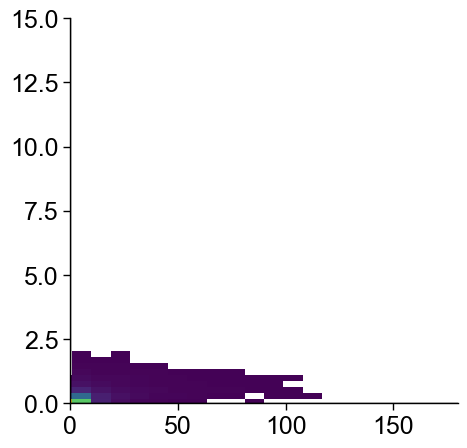

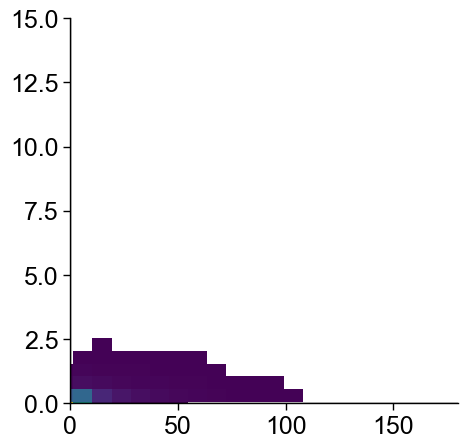

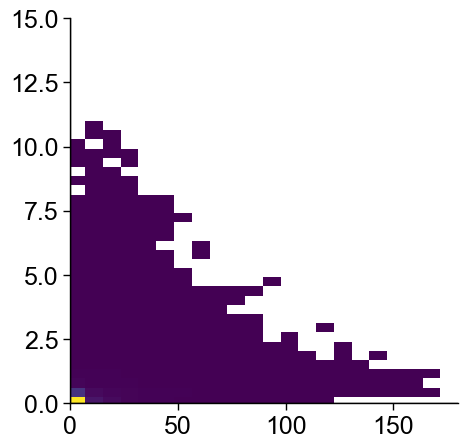

In [50]:
plot_df = df[df.DN == 'imposter'].copy().reset_index(drop=True)

analysis_ynames = ["abs_v_fwd","abs_v_ang"]

for index, row in plot_df.iloc[:5].iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']
    csv_path = row['abs_file_path']

    singleDN_df = load_recording(csv_path=csv_path)
    x, ys = get_xy(singleDN_df,analysis_ynames)

    plt.figure(figsize=[5,5])
    ax = plt.gca()
    sns.histplot(x=ys[:,1], y=ys[:,0], bins=50, pthresh=.1, cmap="viridis", ax=ax)
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)
    ax.set_ylim([0,15])
    ax.set_xlim([0,180])
    plt.show()

    

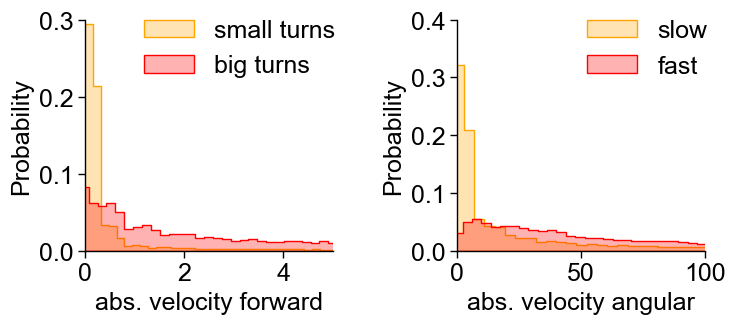

In [86]:
fig, axes = plt.subplots(1,2,figsize=[8,3])
axes=axes.flatten()

ax=axes[0]
sns.histplot(x=ys[ np.where((ys[:,1] > 1) & (ys[:,1] <= 10))[0]  ,0], bins=100, color='orange', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='small turns')
sns.histplot(x=ys[ ys[:,1] > 10   ,0], bins=100, pthresh=.1, color='red', ax=ax, element='step',stat='probability',alpha=0.3,label='big turns')
ax.set_xlim([0,5])
ax.set_xlabel('abs. velocity forward')
ax.legend(bbox_to_anchor=(1.1, 1.1),loc=1,frameon=False)

ax=axes[1]
sns.histplot(x=ys[ np.where((ys[:,0] > 0.2) & (ys[:,0] <= 2))[0]  ,1], bins=100, color='orange', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='slow')
sns.histplot(x=ys[ ys[:,0] > 2   ,1], bins=100, pthresh=.1, color='red', ax=ax, element='step',stat='probability',alpha=0.3,label='fast')
ax.set_xlim([0,100])
ax.set_xlabel('abs. velocity angular')
ax.legend(bbox_to_anchor=(1.1, 1.1),loc=1,frameon=False)

plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('fig/big_turns_fast_speed.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [124]:
turn_th = np.nanmedian(ys[:,1])
speed_th = np.nanquantile(ys[:,0],[0.75]) # 3*np.nanmedian(ys[:,0])

turning_frames = ys[:,1] > turn_th
high_speed_frames = ys[:,0] > speed_th

100*np.nansum(turning_frames*high_speed_frames)/np.sum(turning_frames)

np.float64(47.57961421550524)

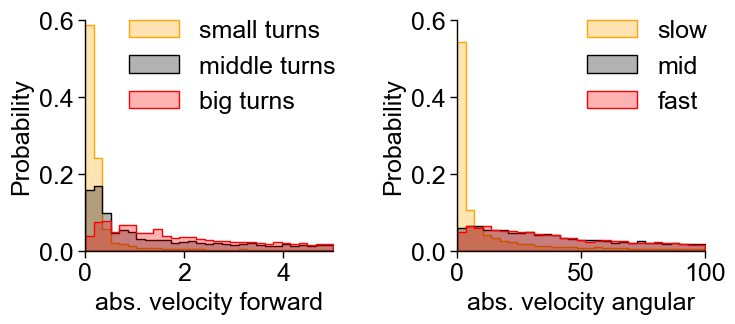

In [102]:
turn_th = 10
speed_th = 1
mutliplier = 5
nbins = 30

fig, axes = plt.subplots(1,2,figsize=[8,3])
axes=axes.flatten()

ax=axes[0]
sns.histplot(x=ys[ np.where((ys[:,1] > 1) & (ys[:,1] <= turn_th))[0]  ,0], bins=np.linspace(0,5,nbins), color='orange', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='small turns')
sns.histplot(x=ys[ np.where((ys[:,1] > turn_th) & (ys[:,1] <= mutliplier*turn_th))[0]  ,0], bins=np.linspace(0,5,nbins), color='k', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='middle turns')
sns.histplot(x=ys[ ys[:,1] > mutliplier*turn_th   ,0], bins=np.linspace(0,5,nbins), pthresh=.1, color='red', ax=ax, element='step',stat='probability',alpha=0.3,label='big turns')
ax.set_xlim([0,5])
ax.set_xlabel('abs. velocity forward')
ax.legend(bbox_to_anchor=(1.1, 1.1),loc=1,frameon=False)

ax=axes[1]
sns.histplot(x=ys[ np.where((ys[:,0] > 0.1) & (ys[:,0] <= speed_th))[0]  ,1], bins=np.linspace(0,100,nbins), color='orange', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='slow')
sns.histplot(x=ys[ np.where((ys[:,0] > speed_th) & (ys[:,0] <= mutliplier*speed_th))[0]  ,1], bins=np.linspace(0,100,nbins), color='k', pthresh=.1, ax=ax, element='step',stat='probability',alpha=0.3,label='mid')
sns.histplot(x=ys[ ys[:,0] > mutliplier*speed_th   ,1], bins=np.linspace(0,100,nbins), pthresh=.1, color='red', ax=ax, element='step',stat='probability',alpha=0.3,label='fast')
ax.set_xlim([0,100])
ax.set_xlabel('abs. velocity angular')
ax.legend(bbox_to_anchor=(1.1, 1.1),loc=1,frameon=False)

plt.subplots_adjust(hspace=0.5,wspace=0.5)
# plt.savefig('fig/big_turns_fast_speed.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

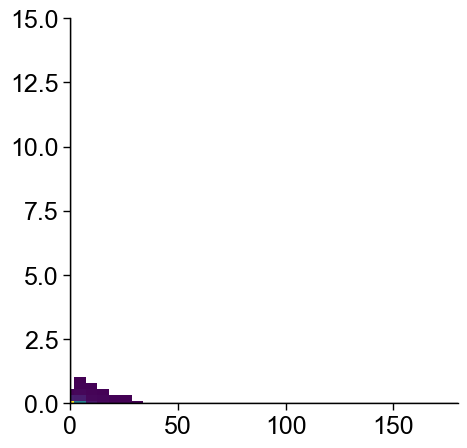

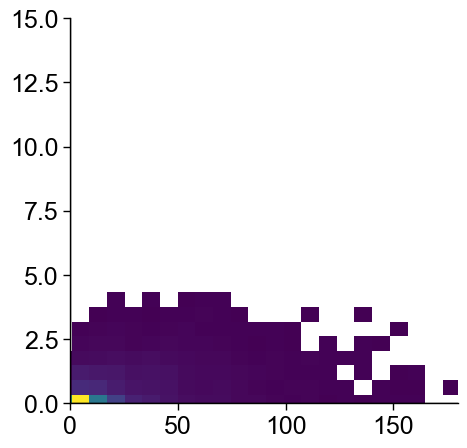

In [4]:
plot_df = df[df.DN == 'MDN'].copy().reset_index(drop=True)

analysis_ynames = ["v_fwd","abs_v_ang"]

for index, row in plot_df.iloc[:2].iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']
    csv_path = row['abs_file_path']

    singleDN_df = load_recording(csv_path=csv_path)
    x, ys = get_xy(singleDN_df,analysis_ynames)

    plt.figure(figsize=[5,5])
    ax = plt.gca()
    sns.histplot(x=ys[:,1], y=ys[:,0], bins=50, pthresh=.1, cmap="viridis", ax=ax)
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)
    ax.set_ylim([0,15])
    ax.set_xlim([0,180])
    plt.show()

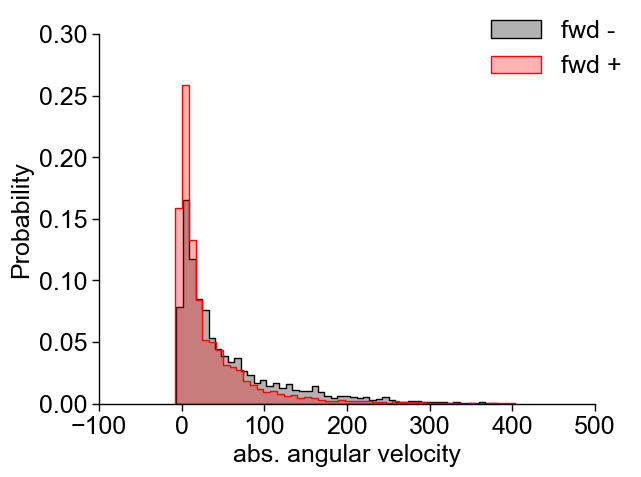

In [7]:
ax=plt.gca()
sns.histplot(x=ys[ ys[:,0] < 0   ,1], bins=50, pthresh=.1, color='k', ax=ax, element='step',stat='probability',alpha=0.3,label='fwd -')
sns.histplot(x=ys[ ys[:,0] > 0   ,1], bins=50, pthresh=.1, color='red', ax=ax, element='step',stat='probability',alpha=0.3,label='fwd +')
# ax.set_xlim([0,5])
ax.set_xlabel('abs. angular velocity')
ax.legend(bbox_to_anchor=(1.1, 1.1),loc=1,frameon=False)
plt.show()


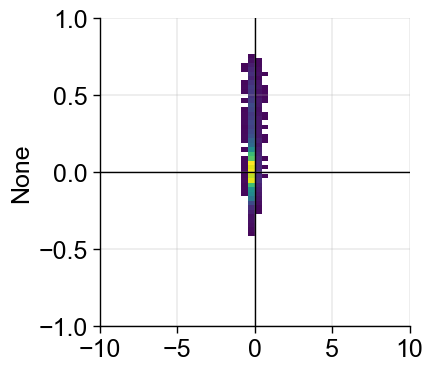

In [135]:
with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
    y_pred_dict = pickle.load(handle)

y_m = y_m_dict[filename]
y_pred = y_pred_dict[filename]
rolling_corr_prediction = pd.Series(y_m[:,1]).rolling(window=window).corr(pd.Series(y_pred[:,1]))
mask = ~np.isnan(rolling_corr_prediction)

plt.figure(figsize=[4,4])
ax = plt.gca()
ax.grid(True,lw=0.3)
ax.axhline(y=0,color='k',lw=1)
ax.axvline(x=0,color='k',lw=1)
# sns.kdeplot(x=y_m[mask,ifeature], y=rolling_corr_prediction[mask], fill=True, cmap="mako", thresh=0.05)
sns.histplot(x=y_m[mask,0], y=rolling_corr_prediction[mask], bins=50, pthresh=.1, cmap="viridis", ax=ax)
ax.set_xlim([-10,10])
plt.show()



2022_11_25_0009 may have constant prediction
2023_01_26_0020 may have constant prediction
2023_07_14_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1603230294.py:49: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1603230294.py:50: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1603230294.py:56: RuntimeWarning: Mean of empty slice
  axes[2].plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1603230294.py:57: RuntimeWarning: Mean of empty slice
  axes[2].fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)


2022_07_05_0010 may have constant prediction
2022_07_05_0013 may have constant prediction
2024_11_29_0001 may have constant prediction


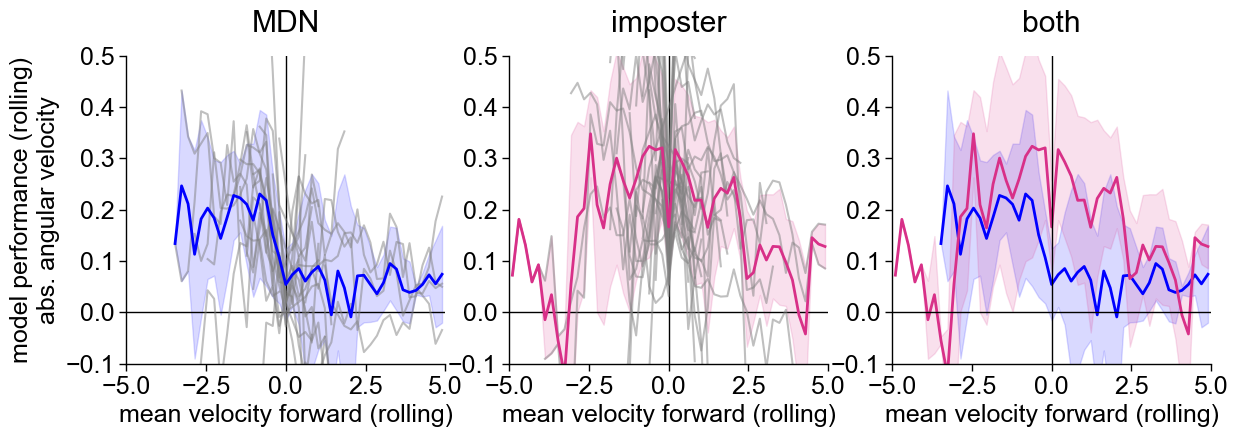

In [ ]:
analysis_ynames = ["v_fwd","abs_v_ang"]
xlims = [-5,5]
bins = np.linspace(xlims[0],xlims[1],50) 
final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2
rolling_window = 300

fig, axes = plt.subplots(1,3,figsize=[14,4])

for ax, DN, color in zip(axes,['MDN','imposter'], ['b','#D83088']):
    plot_df = df[df.DN == DN].copy().reset_index(drop=True)

    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_m.pkl'.format(*analysis_ynames), 'rb') as handle:
        y_m_dict = pickle.load(handle)
    with open(raw_data_dir_path+'/dat/continuous_{0}_{1}_y_pred.pkl'.format(*analysis_ynames), 'rb') as handle:
        y_pred_dict = pickle.load(handle)


    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)

    collected_traces = []
    for index, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,0]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,1]).rolling(window=rolling_window).corr(pd.Series(y_pred[:,1]))
            rolling_mean_fwd = pd.Series(y_m[:,0]).rolling(window=rolling_window).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
            ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5) #, marker='o')

    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan
    
    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
    ax.set_xlim(xlims)
    ax.set_ylim([-0.1,0.5])
    ax.set_xlabel('mean velocity forward (rolling)')
    ax.set_title(DN,y=1.05)

    axes[2].plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    axes[2].fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)

axes[2].axhline(y=0,color='k',lw=1)
axes[2].axvline(x=0,color='k',lw=1)
axes[2].set_xlim(xlims)
axes[2].set_ylim([-0.1,0.5])
axes[2].set_xlabel('mean velocity forward (rolling)')
axes[2].set_title('both',y=1.05)

axes[0].set_ylabel('model performance (rolling)\nabs. angular velocity')
plt.savefig('fig/ang_vel_prediction_vs_vfwd_2.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

abs_v_ang 3 v_fwd 0


C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1463616697.py:58: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1463616697.py:59: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1463616697.py:65: RuntimeWarning: Mean of empty slice
  axes[2].plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\1463616697.py:66: RuntimeWarning: Mean of empty slice
  axes[2].fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)


2024_11_29_0001 may have constant prediction


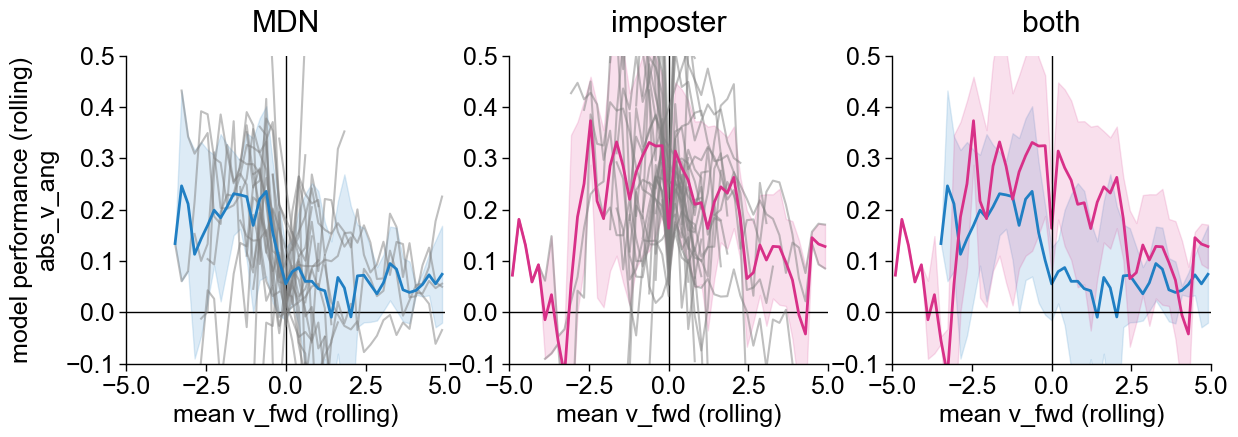

In [ ]:
analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
rolling_window = 300
# color_perside_dict, color_perDN_dict

reference = 'v_fwd'
xlims = [-5,5]
bins = np.linspace(xlims[0],xlims[1],50) 
final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2

predicted = 'abs_v_ang'

idx_predicted = analysis_ynames.index(predicted)
idx_reference = analysis_ynames.index(reference)
print(predicted, idx_predicted, reference, idx_reference)

with open(raw_data_dir_path+'/dat/continuous_all_y_m.pkl', 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_all_y_pred.pkl', 'rb') as handle:
    y_pred_dict = pickle.load(handle)

fig, axes = plt.subplots(1,3,figsize=[14,4])

for ax, DN in zip(axes,['MDN','imposter']):
    plot_df = df[df.DN == DN].copy().reset_index(drop=True)
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)
    color = color_perDN_dict[DN]

    collected_traces = []
    for index, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
            ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5) #, marker='o')

    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan
    
    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
    ax.set_xlim(xlims)
    ax.set_ylim([-0.1,0.5])
    ax.set_xlabel(f'mean {reference} (rolling)')
    ax.set_title(DN,y=1.05)

    axes[2].plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    axes[2].fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)

axes[2].axhline(y=0,color='k',lw=1)
axes[2].axvline(x=0,color='k',lw=1)
axes[2].set_xlim(xlims)
axes[2].set_ylim([-0.1,0.5])
axes[2].set_xlabel(f'mean {reference} (rolling)')
axes[2].set_title('both',y=1.05)

axes[0].set_ylabel(f'model performance (rolling)\n{predicted}')
# plt.savefig('fig/ang_vel_prediction_vs_vfwd_2.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

abs_v_ang 3 v_fwd 0


C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2032773069.py:61: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2032773069.py:62: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)


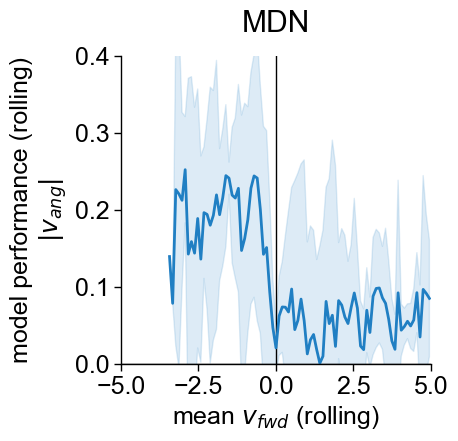

In [210]:
analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']

labels_dict = {'v_fwd':r'$v_{fwd}$','v_ang':r'$v_{ang}$','abs_v_fwd':r'$|v_{fwd}|$','abs_v_ang':r'$|v_{ang}|$','pos_v_fwd':r'$v_{fwd}^+$','pos_v_ang':r'$v_{ang}^+$','neg_v_fwd':r'$v_{fwd}^-$','neg_v_ang':r'$v_{ang}^-$'}

rolling_window = 300

reference = 'v_fwd'
xlims = [-5,5]
bins = np.linspace(xlims[0],xlims[1],100) 
final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2

predicted = 'abs_v_ang'

idx_predicted = analysis_ynames.index(predicted)
idx_reference = analysis_ynames.index(reference)
print(predicted, idx_predicted, reference, idx_reference)

with open(raw_data_dir_path+'/dat/continuous_all_y_m.pkl', 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_all_y_pred.pkl', 'rb') as handle:
    y_pred_dict = pickle.load(handle)

plt.figure(figsize=[4,4])
ax = plt.gca()
DN = 'MDN'

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
ax.axhline(y=0,color='k',lw=1)
ax.axvline(x=0,color='k',lw=1)
color = color_perDN_dict[DN]

collected_traces = []
for index, row in plot_df.iterrows():
    filename = row['filename']

    y_m = y_m_dict[filename]
    y_pred = y_pred_dict[filename]

    if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
        print(f"{filename} may have constant prediction")
    else:
        rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
        rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
        mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

        statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
        bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
        if np.any(~np.isnan(statistic)):
            stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
        else:
            stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
        stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
        stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
        
        collected_traces.append(stat_estimate)
        # ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5)

stack_traces = np.vstack(collected_traces).T
stack_traces[np.isinf(stack_traces)] = np.nan

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
ax.set_xlim(xlims)
ax.set_ylim([0,0.4])
ax.set_xlabel(f'mean {labels_dict[reference]} (rolling)')
ax.set_title(DN,y=1.05)

ax.set_ylabel(f'model performance (rolling)\n{labels_dict[predicted]}')
plt.savefig('fig/MDN_predicts_backwards_turn.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

abs_v_ang 3 v_ang 1
2024_11_29_0001 may have constant prediction


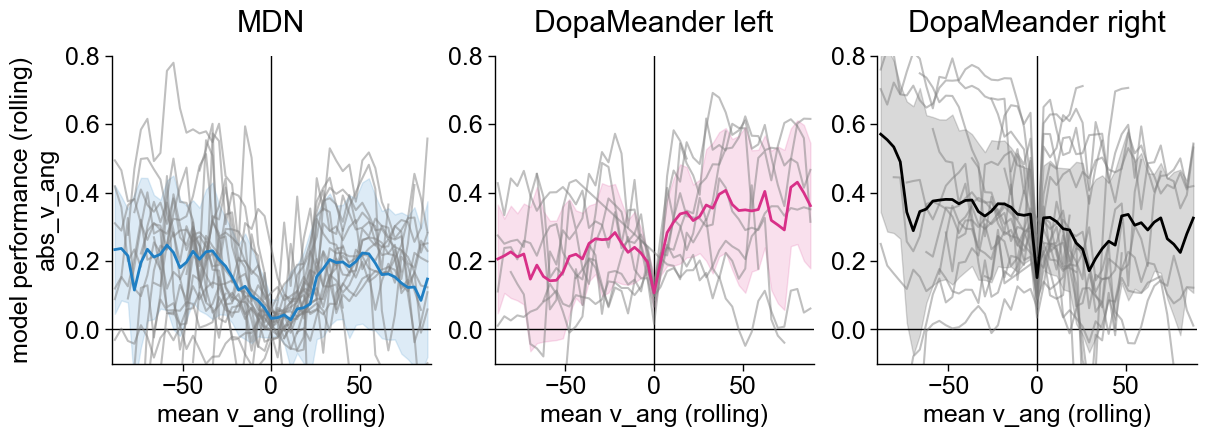

In [ ]:
analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
rolling_window = 300

reference = 'v_ang'
xlims = [-90,90]
bins = np.linspace(xlims[0],xlims[1],50) 
final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2

predicted = 'abs_v_ang'

idx_predicted = analysis_ynames.index(predicted)
idx_reference = analysis_ynames.index(reference)
print(predicted, idx_predicted, reference, idx_reference)

with open(raw_data_dir_path+'/dat/continuous_all_y_m.pkl', 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_all_y_pred.pkl', 'rb') as handle:
    y_pred_dict = pickle.load(handle)

fig, axes = plt.subplots(1,3,figsize=[14,4])
axes = axes.flatten()

for ax in axes.flatten():
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)

for iax, DN in zip([0,1,2],['MDN','DopaMeander left','DopaMeander right']):
    plot_df = df.copy().reset_index(drop=True)
    plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
    plot_df.loc[plot_df.DN == 'DopaMeander','DN'] = plot_df.loc[plot_df.DN == 'DopaMeander','DN'] + ' ' + plot_df.loc[plot_df.DN == 'DopaMeander','side']
    plot_df = plot_df[plot_df.DN == DN].reset_index(drop=True)  

    ax = axes[iax]
    color = color_perside_dict[DN]

    collected_traces = []
    for index, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
            ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5) #, marker='o')

    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan
    
    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
    ax.set_xlim(xlims)
    ax.set_ylim([-0.1,0.8])
    ax.set_xlabel(f'mean {reference} (rolling)')
    ax.set_title(DN,y=1.05)
    
# for ax, title in zip(axes.flatten(),['MDN','DopaMeander']):
#     ax.set_title(title,y=1.05)

axes[0].set_ylabel(f'model performance (rolling)\n{predicted}')
# plt.savefig('fig/ang_vel_prediction_vs_vfwd_2.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

abs_v_fwd 2 v_fwd 0
2022_11_25_0011 may have constant prediction
2023_02_21_0006 may have constant prediction
2023_08_15_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:66: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:67: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:66: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:67: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin

2024_11_29_0001 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:66: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_12012\2873789995.py:67: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


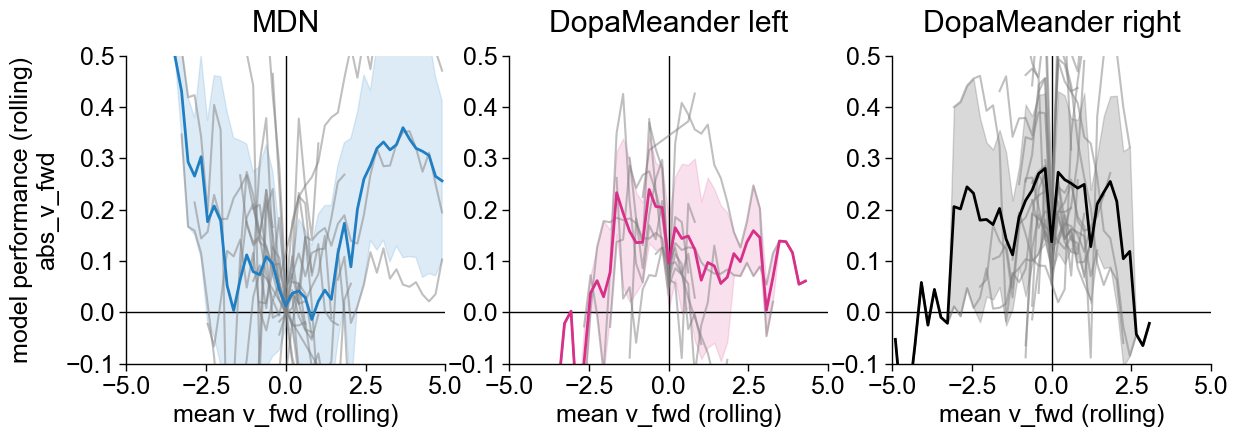

In [200]:
analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
rolling_window = 300
# color_perside_dict, color_perDN_dict

reference = 'v_fwd'
xlims = [-5,5]
bins = np.linspace(xlims[0],xlims[1],50) 
final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2

predicted = 'abs_v_fwd'

idx_predicted = analysis_ynames.index(predicted)
idx_reference = analysis_ynames.index(reference)
print(predicted, idx_predicted, reference, idx_reference)

with open(raw_data_dir_path+'/dat/continuous_all_y_m.pkl', 'rb') as handle:
    y_m_dict = pickle.load(handle)
with open(raw_data_dir_path+'/dat/continuous_all_y_pred.pkl', 'rb') as handle:
    y_pred_dict = pickle.load(handle)

fig, axes = plt.subplots(1,3,figsize=[14,4])
axes = axes.flatten()

for ax in axes.flatten():
    ax.axhline(y=0,color='k',lw=1)
    ax.axvline(x=0,color='k',lw=1)

for iax, DN in zip([0,1,2],['MDN','DopaMeander left','DopaMeander right']):
    plot_df = df.copy().reset_index(drop=True)
    plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
    plot_df.loc[plot_df.DN == 'DopaMeander','DN'] = plot_df.loc[plot_df.DN == 'DopaMeander','DN'] + ' ' + plot_df.loc[plot_df.DN == 'DopaMeander','side']
    plot_df = plot_df[plot_df.DN == DN].reset_index(drop=True)  

    ax = axes[iax]
    color = color_perside_dict[DN]

    collected_traces = []
    for index, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
            ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5) #, marker='o')

    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan
    
    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=2, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-np.nanstd(stack_traces,axis=1), np.nanmean(stack_traces,axis=1)+np.nanstd(stack_traces,axis=1), color=color, alpha=0.15)
    ax.set_xlim(xlims)
    ax.set_ylim([-0.1,0.5])
    ax.set_xlabel(f'mean {reference} (rolling)')
    ax.set_title(DN,y=1.05)
    
# for ax, title in zip(axes.flatten(),['MDN','DopaMeander']):
#     ax.set_title(title,y=1.05)

axes[0].set_ylabel(f'model performance (rolling)\n{predicted}')
# plt.savefig('fig/ang_vel_prediction_vs_vfwd_2.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()